In [2]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, \
forecast_by_week, train_test_split
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp, hp_color_plot
from PythonFiles.Configuration import Configuration
from PythonFiles.HpTuning import get_data, restore_HP_results, objectiveFNN, generate_model_results_by_hp_dict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from ray import tune
configuration = Configuration()

In [3]:
#experiment_path = "/home/reffert/ray_results/objectiveFNN_2023-05-27_09-47-44"
#df = restore_HP_results(experiment_path, objectiveFNN, train, test, configuration)
df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/FNN_Hyperparameter_results_30_05.csv", sep=',')
hp_search_space = {
    "num_hidden_dimensions": tune.grid_search([[40,40],[80,80],[20,20]]),
    "context_length":tune.grid_search([4, 52, 104]),
    "epochs":tune.grid_search([100, 200]),
    "prediction_length" : tune.grid_search([4]), 
    "num_batches_per_epoch":tune.grid_search([50]),
    "batch_normalization":tune.grid_search([True, False]),
    "batch_size":tune.grid_search([32]),
    }
if "config/num_hidden_dimensions"in list(df.columns):
    df["config/num_hidden_dimensions"]=df["config/num_hidden_dimensions"].apply(tuple)
#df = df.loc[df["config/prediction_length"]==4]

In [8]:
model_results_by_hp, overall_df = generate_model_results_by_hp_dict(df, hp_search_space)

                           total_modelruns  independent_combinations
modelruns_per_combination                                           
5.0                                    180                      36.0


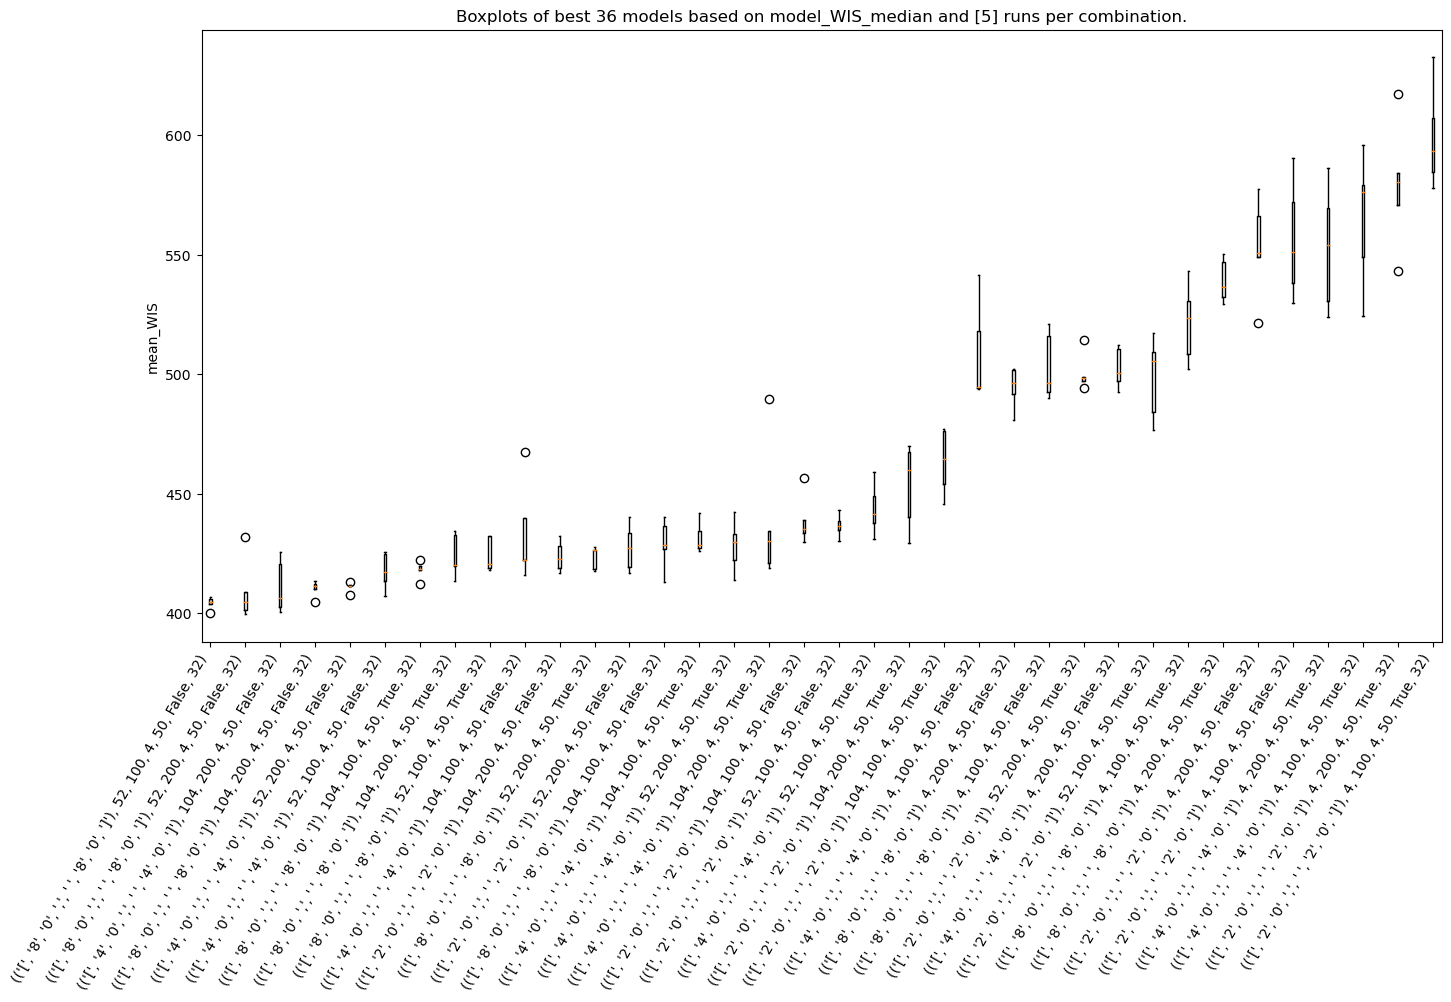

In [9]:
plot_model_results_by_hp(configuration, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "bp")

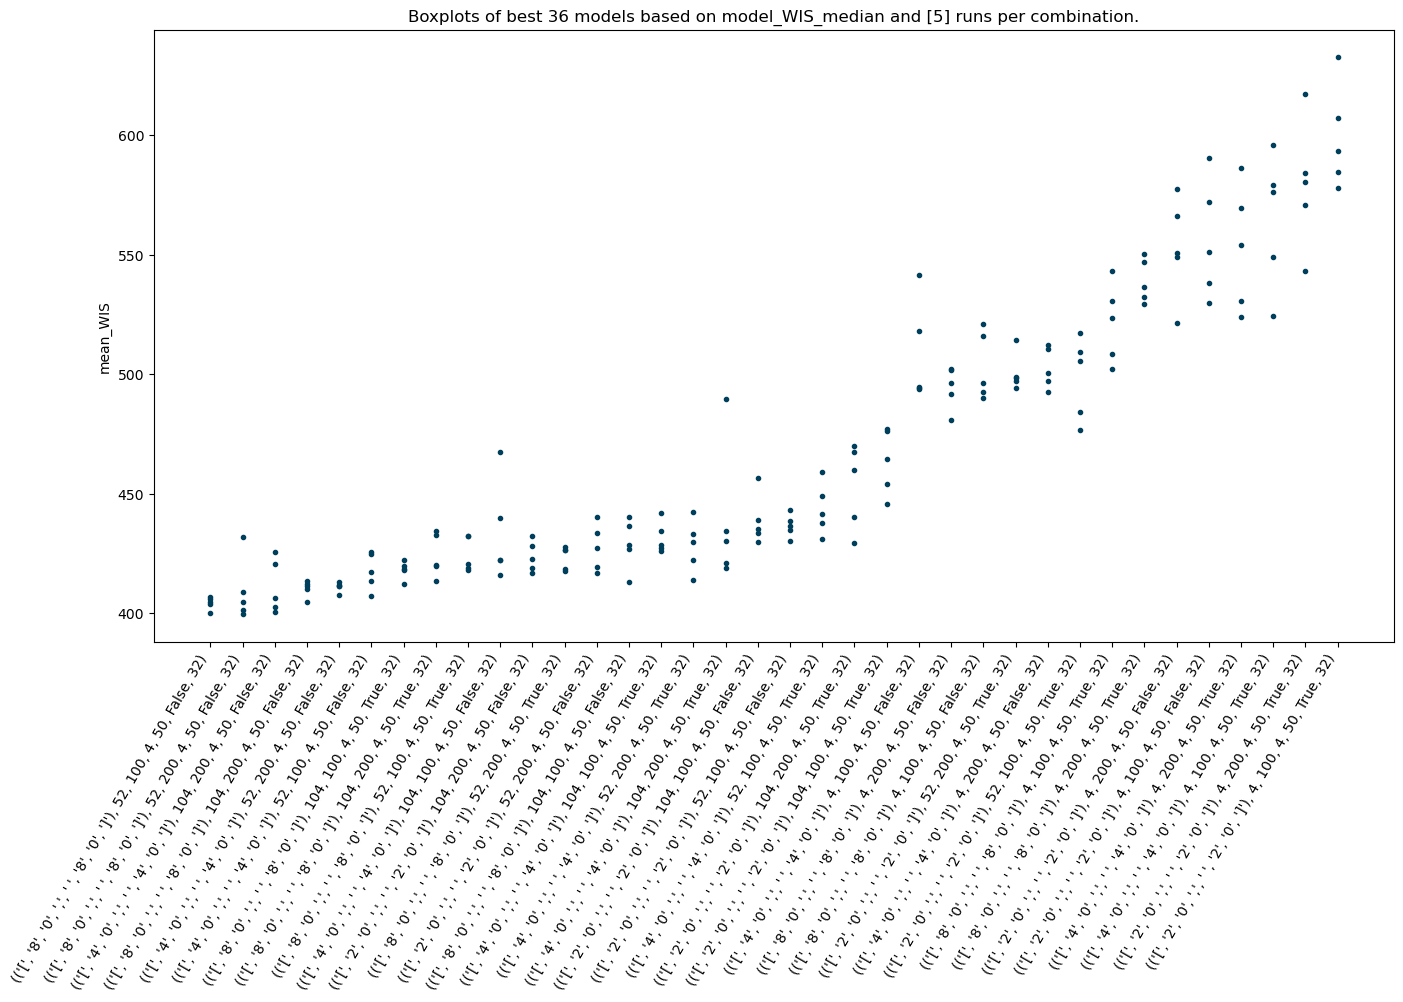

In [10]:

'''
col: "mean_WIS", "time_this_iter_s"
sort_by: "mean_WIS", "time_this_iter_s", "model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median"(, "shape") 
plottype: "unordered"(not ordered), "best" or "worst"
'''
plot_model_results_by_hp(configuration, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "scatter")

In [11]:
added_cols = ["model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median", "shape"] 
# We can't drop duplicates of num_hidden_dimensions as this column is reported as lists
display(overall_df.sort_values("model_WIS_mean")[added_cols+[col for col in df.columns if ("config" in col)]].drop_duplicates().head(20))

,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_WIS_median,model_time_mean,model_time_variance,model_time_sd,model_time_median,shape,config/batch_normalization,config/batch_size,config/context_length,config/epochs,config/num_batches_per_epoch,config/num_hidden_dimensions,config/prediction_length
159,404.274504,6.581577,2.565458,404.585532,941.174707,107967.262809,328.583723,1168.548839,5.0,False,32,52,100,50,"([, 8, 0, ,, , 8, 0, ])",4
21,409.350567,172.180297,13.121749,404.878319,1817.121160,403858.397368,635.498542,2134.354753,5.0,False,32,52,200,50,"([, 8, 0, ,, , 8, 0, ])",4
131,410.393279,11.015576,3.318972,411.415524,1724.309561,327039.408586,571.873595,1927.895773,5.0,False,32,104,200,50,"([, 8, 0, ,, , 8, 0, ])",4
45,411.084625,3.935646,1.983846,411.530227,1765.399536,392442.967439,626.452686,2187.159524,5.0,False,32,52,200,50,"([, 4, 0, ,, , 4, 0, ])",4
119,411.198520,126.223706,11.234932,406.599831,1785.222644,375657.130791,612.908746,2040.612828,5.0,False,32,104,200,50,"([, 4, 0, ,, , 4, 0, ])",4
3,417.605276,60.371465,7.769908,417.151217,967.475242,94774.432856,307.854564,1020.277971,5.0,False,32,52,100,50,"([, 4, 0, ,, , 4, 0, ])",4
160,418.190107,13.119111,3.622031,418.490181,973.002576,105670.983030,325.070735,1091.965571,5.0,True,32,104,100,50,"([, 8, 0, ,, , 8, 0, ])",4
164,423.410558,23.341415,4.831295,426.467331,1825.783236,400312.812539,632.702784,2269.834886,5.0,True,32,52,200,50,"([, 8, 0, ,, , 8, 0, ])",4
35,423.752457,41.757044,6.461969,422.801681,1679.569185,356937.621515,597.442568,1622.534257,5.0,False,32,104,200,50,"([, 2, 0, ,, , 2, 0, ])",4
94,424.092550,82.127460,9.062420,420.324057,1760.102528,373274.733355,610.962137,2047.925153,5.0,True,32,104,200,50,"([, 8, 0, ,, , 8, 0, ])",4


36
180


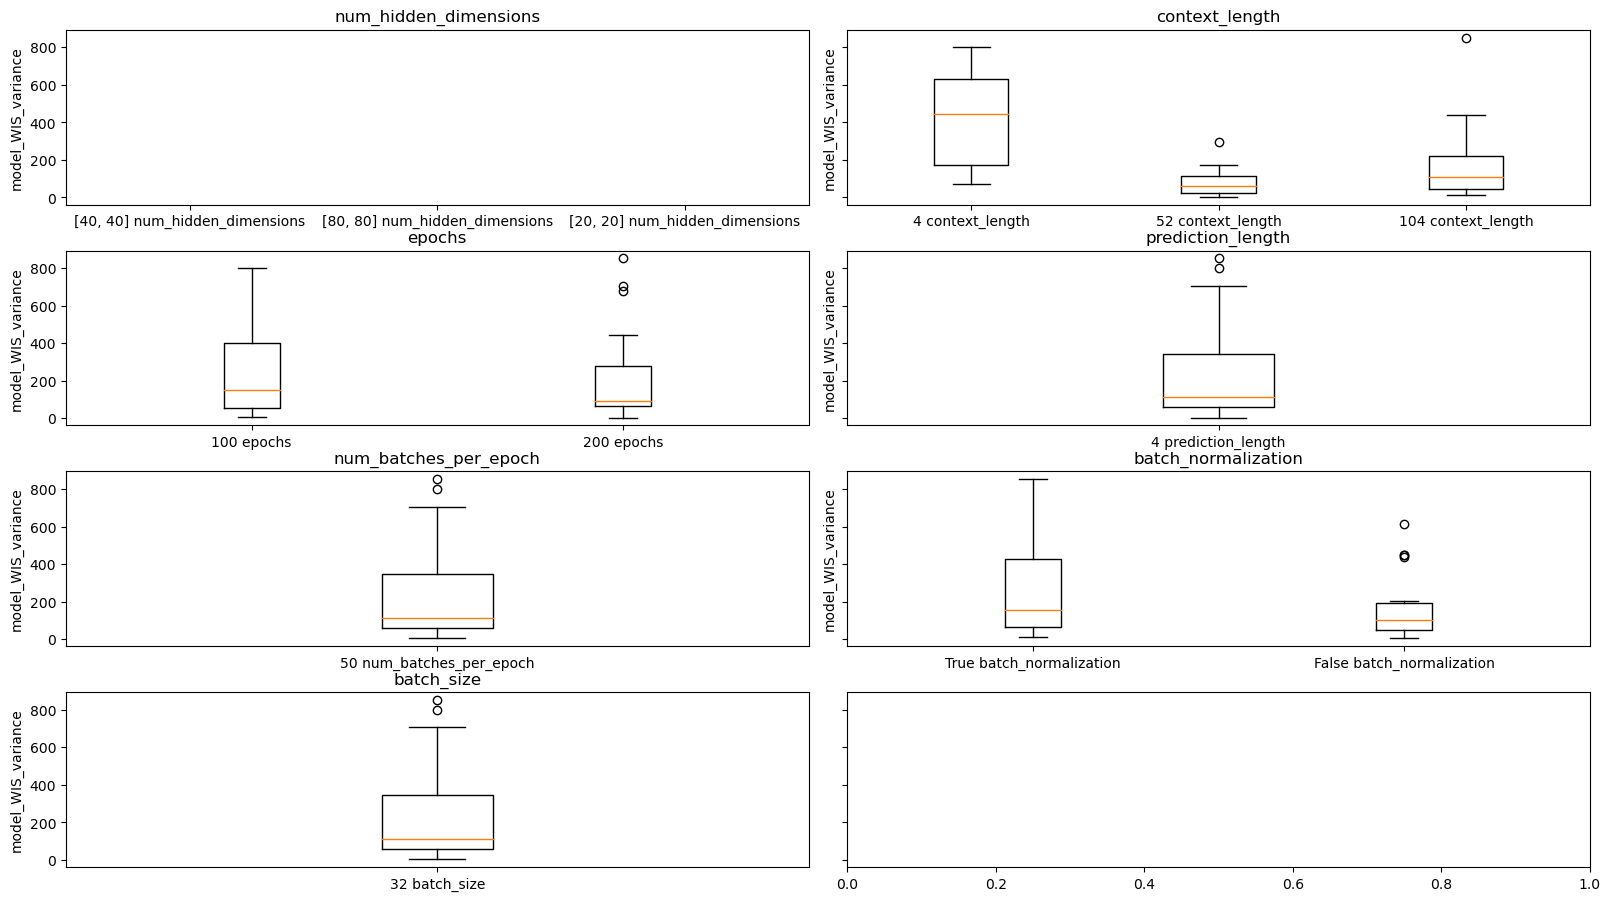

________________


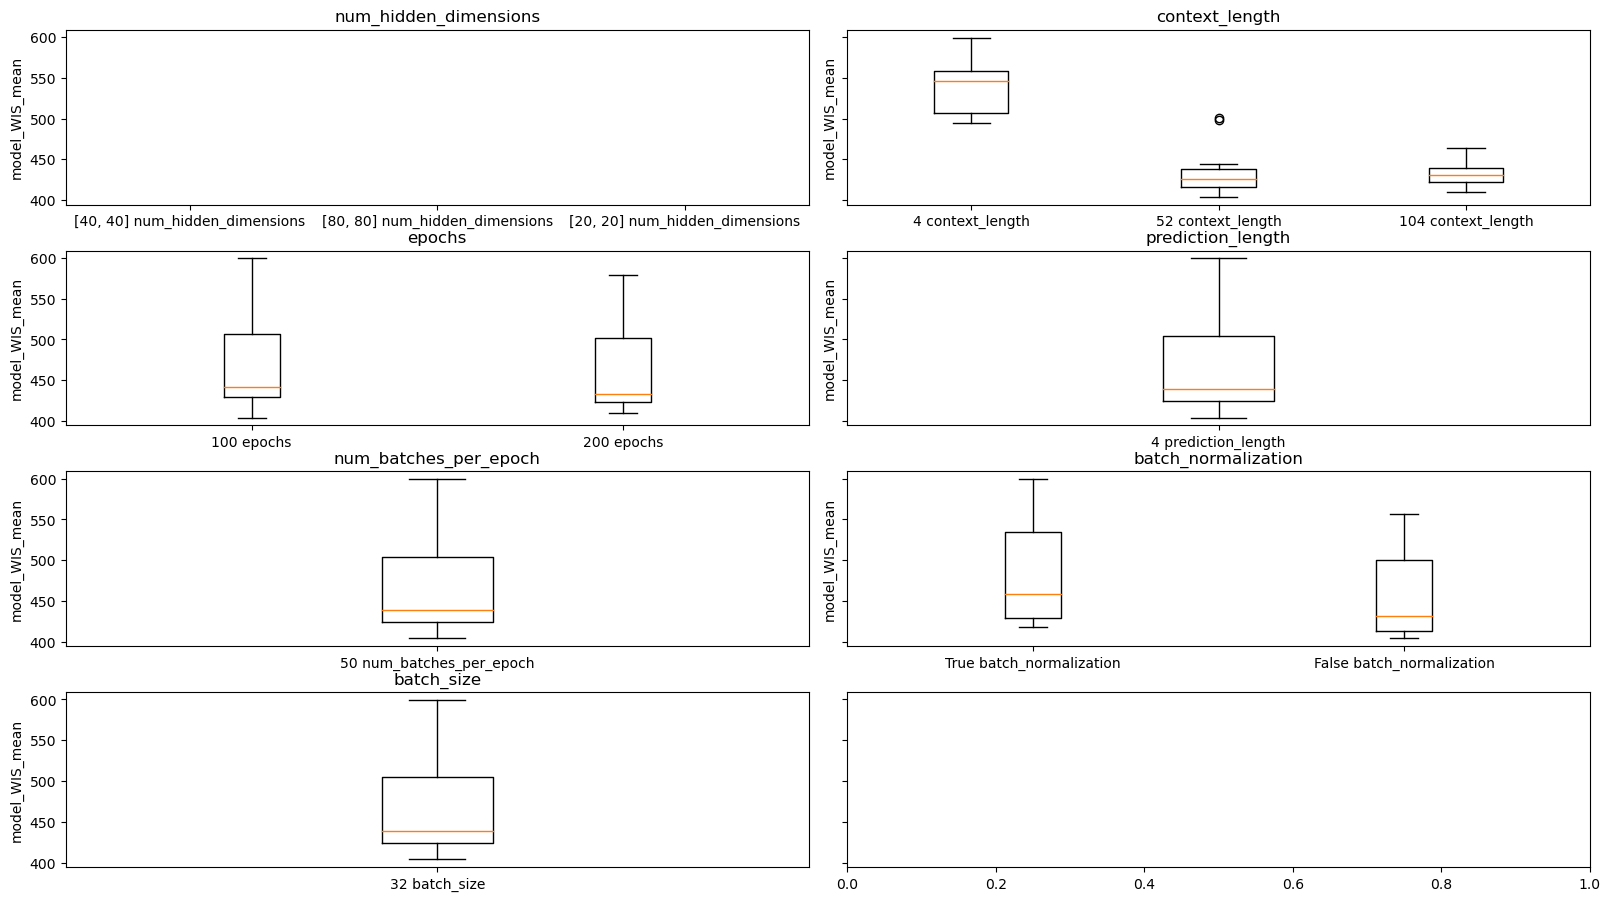

In [13]:
unique_df = overall_df[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()
def hyperparameter_boxplots1(results_df, hp_search_space, col="mean_WIS"):
    """
    Plot the hyperparameters as boxplots.
    """
    # Create a dict of filtered dfs and x_tick- renamings
    hp_plots = dict()
    for key in hp_search_space.keys():
        if type(hp_search_space[key]) == type(dict()):
            search_grid = hp_search_space[key][list(hp_search_space[key].keys())[0]]
            #search_grid = [tuple(s) if isinstance(s, list) else s for s in search_grid]
            #print(search_grid)
            hp_plots[key] = {"cols" : [f"{i} {key}" for i in search_grid], "df": [results_df.loc[results_df[f'config/{key}'].apply(lambda x: x == tuple(i)), col] if (isinstance(i, list)) else results_df.loc[results_df[f'config/{key}']==i, col] for i in search_grid]} # the if isinstance is necessary for the num_hidden_layers of the FNN
    # plot the boxplots
    nrows = int(len(hp_plots.keys())/2) + int(len(hp_plots.keys())%2)
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 9), sharey=True)
    fig.tight_layout(pad=1.2)
    plotnumber = [0, 0]
    for key in hp_plots.keys():
        if list(hp_plots.keys()).index(key)%2 == 1:
            plotnumber[1] = 1
        else:
            if list(hp_plots.keys()).index(key) > 1:
                plotnumber[0] += 1
            plotnumber[1] = 0
        axs[tuple(plotnumber)].boxplot(hp_plots[key]["df"])
        axs[tuple(plotnumber)].set_title(key)
        axs[tuple(plotnumber)].set_xticks([i for i in range(1, len(hp_plots[key]["df"])+1)], hp_plots[key]["cols"])
        axs[tuple(plotnumber)].set_ylabel(col)
    plt.show()

print(len(unique_df))
print(len(overall_df))
hyperparameter_boxplots1(unique_df, hp_search_space, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots1(unique_df, hp_search_space, col="model_WIS_mean")

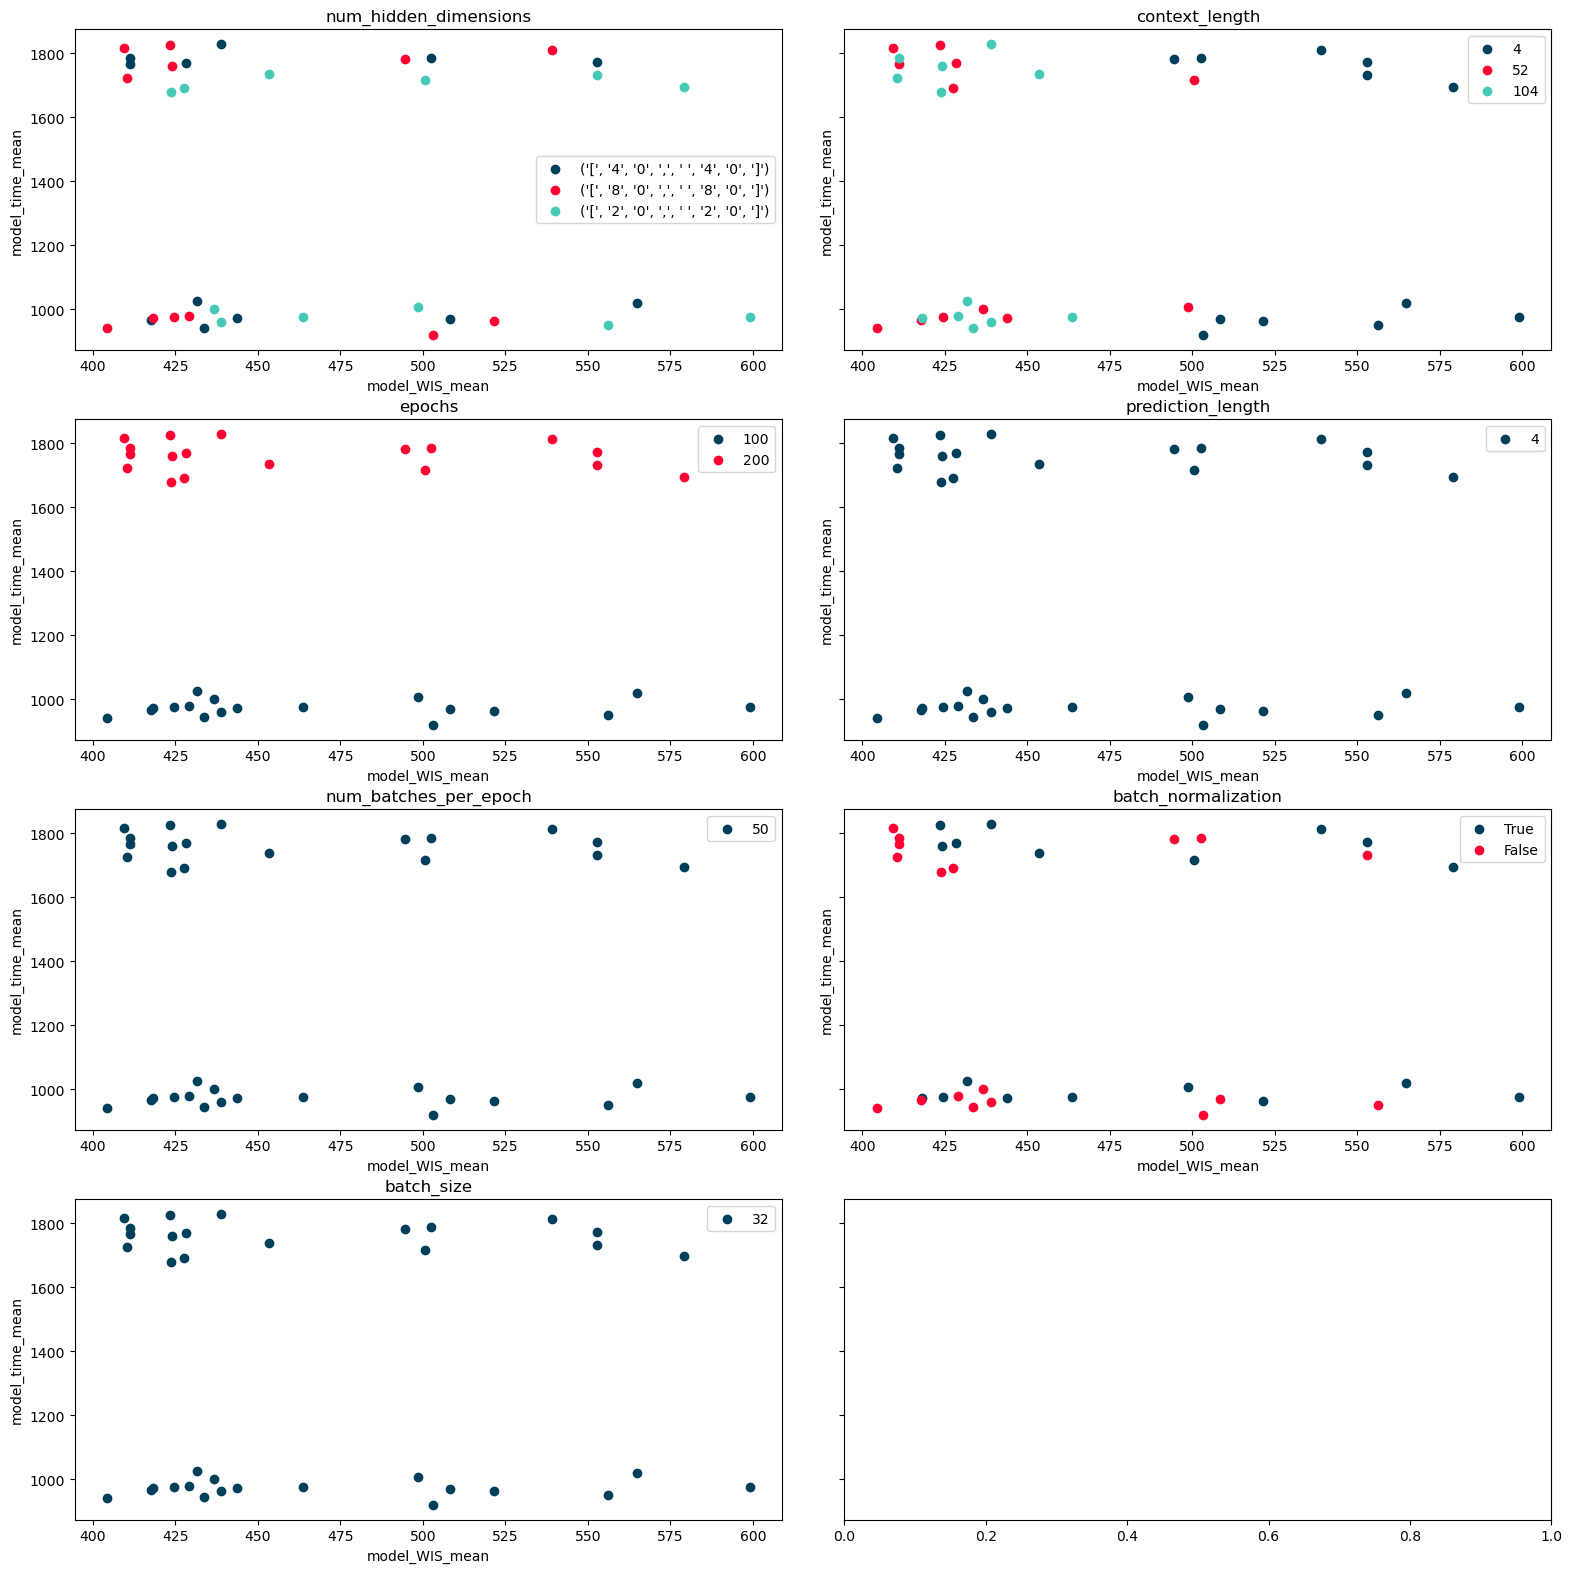

In [14]:
hp_color_plot(configuration, overall_df, hp_search_space, )

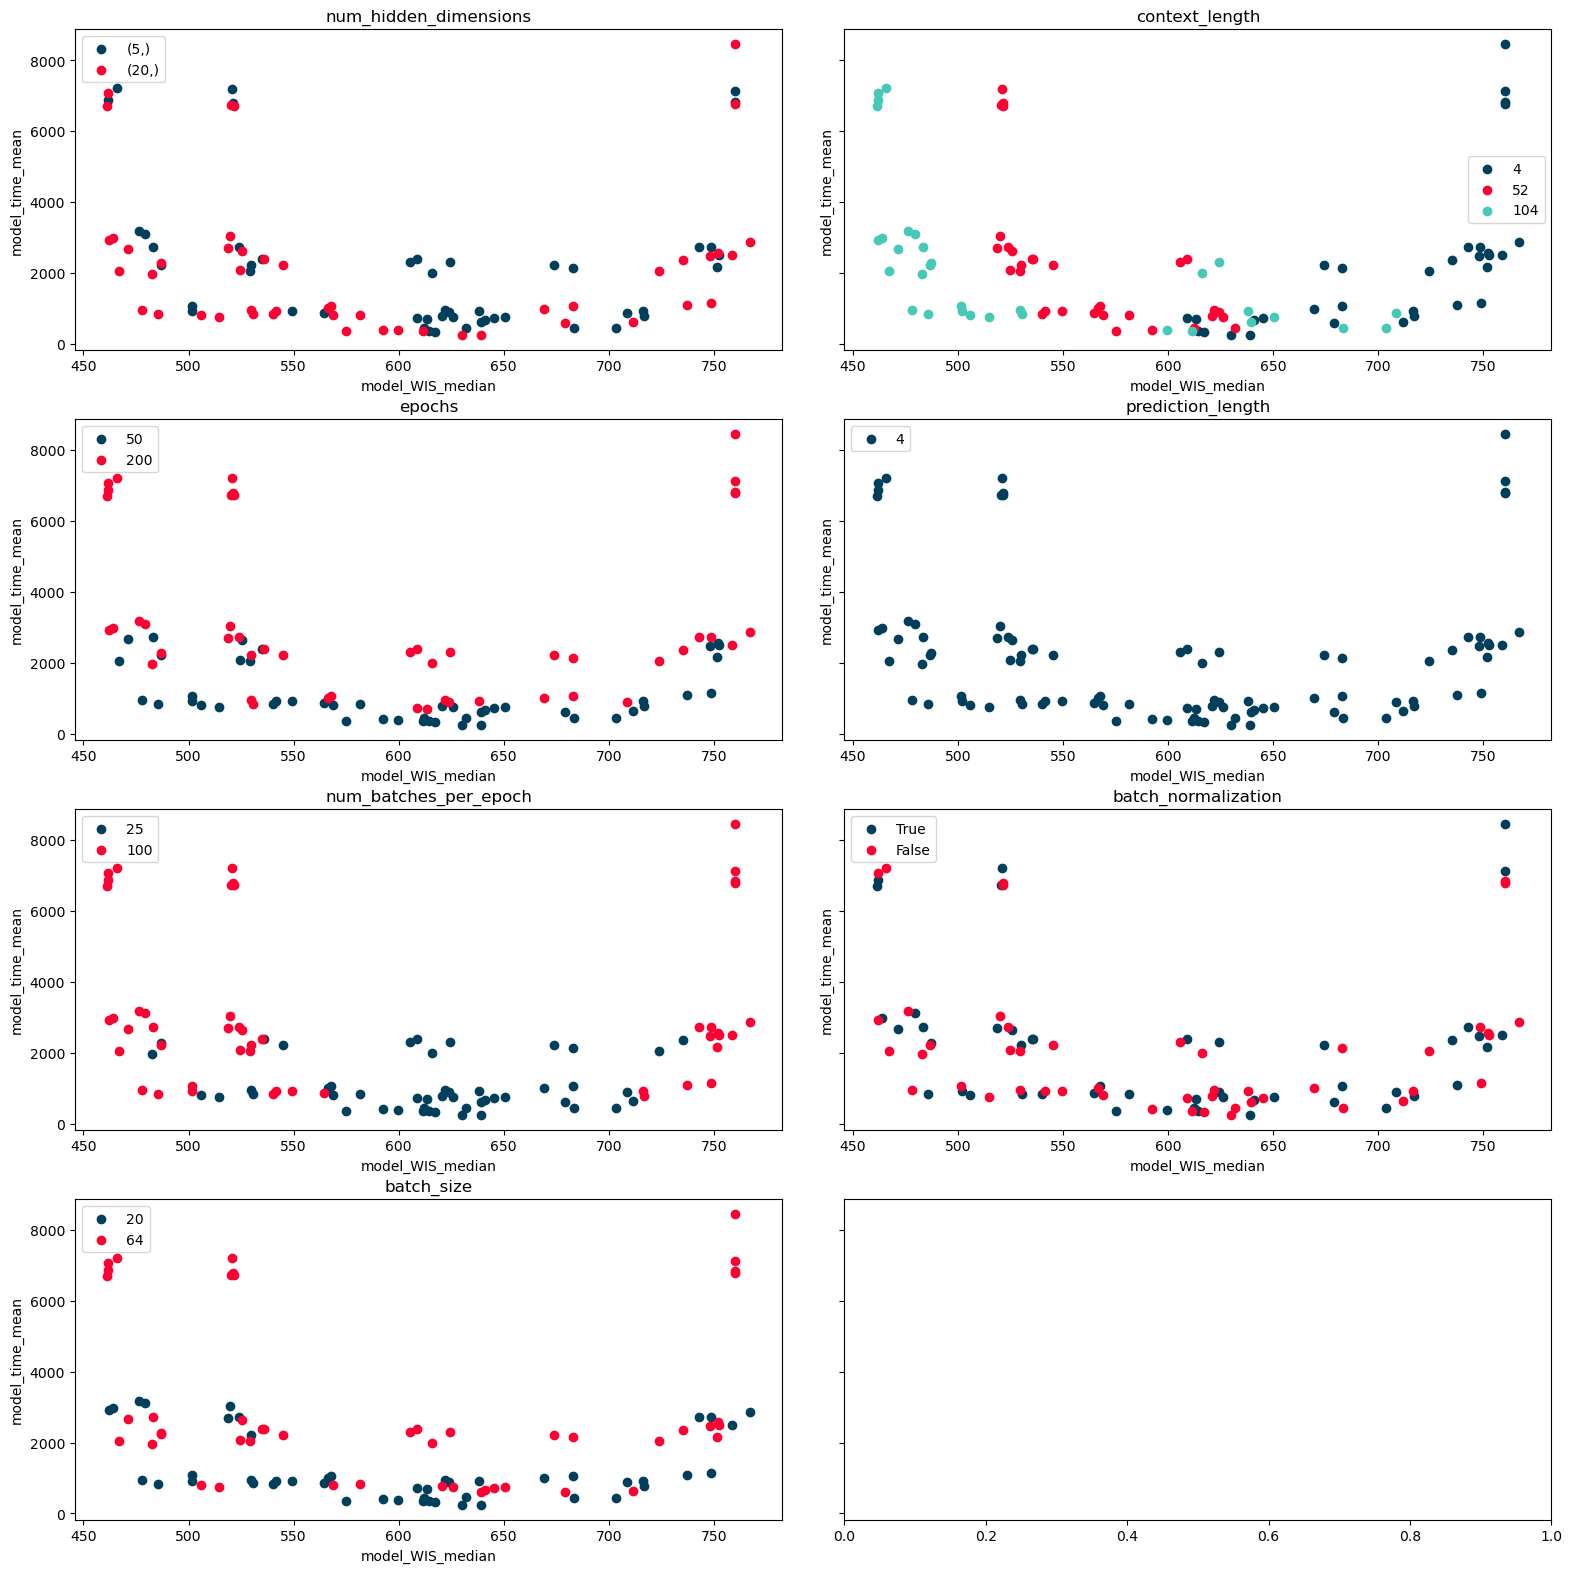

In [15]:
hp_color_plot(configuration, overall_df, hp_search_space, x_axis="model_WIS_median", y_axis="model_time_mean")